# 02. Finetuning GPT-2 with LoRA

In this scenario, I'll fine-tune the pre-trained auto-regressive model, **GPT-2 by OpenAI** (124M parameters), by applying LoRA optimization.

I downloaded the pre-trained model from Hugging Face hub, but fine-tune model with regular PyTorch training loop.

In [85]:
import torch

device = torch.device("cuda")

model_name = "gpt2"

## Prepare Dataset and Dataloaders

I used [dataset](https://github.com/microsoft/LoRA) from the Microsoft's repository.

In [86]:
!wget https://github.com/microsoft/LoRA/raw/main/examples/NLG/data/e2e/train.txt

--2025-12-10 02:46:50--  https://github.com/microsoft/LoRA/raw/main/examples/NLG/data/e2e/train.txt
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/microsoft/LoRA/main/examples/NLG/data/e2e/train.txt [following]
--2025-12-10 02:46:50--  https://raw.githubusercontent.com/microsoft/LoRA/main/examples/NLG/data/e2e/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9624463 (9.2M) [text/plain]
Saving to: ‘train.txt.6’

train.txt.6         100%[===================>]   9.18M  --.-KB/s    in 0.1s    

2025-12-10 02:46:51 (66.2 MB/s) - ‘train.txt.6’ saved [9624463/9624463]



In [87]:
!wget https://github.com/microsoft/LoRA/raw/main/examples/NLG/data/e2e/test.txt

--2025-12-10 02:46:51--  https://github.com/microsoft/LoRA/raw/main/examples/NLG/data/e2e/test.txt
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/microsoft/LoRA/main/examples/NLG/data/e2e/test.txt [following]
--2025-12-10 02:46:51--  https://raw.githubusercontent.com/microsoft/LoRA/main/examples/NLG/data/e2e/test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1351149 (1.3M) [text/plain]
Saving to: ‘test.txt.6’

test.txt.6          100%[===================>]   1.29M  --.-KB/s    in 0.05s   

2025-12-10 02:46:51 (24.2 MB/s) - ‘test.txt.6’ saved [1351149/1351149]



The first 5 rows of the dataset.

In [88]:
!head -n 5 train.txt

name : The Vaults | Type : pub | price : more than £ 30 | customer rating : 5 out of 5 | near : Café Adriatic||The Vaults pub near Café Adriatic has a 5 star rating . Prices start at £ 30 . 
name : The Cambridge Blue | Type : pub | food : English | price : cheap | near : Café Brazil||Close to Café Brazil , The Cambridge Blue pub serves delicious Tuscan Beef for the cheap price of £ 10.50 . Delicious Pub food . 
name : The Eagle | Type : coffee shop | food : Japanese | price : less than £ 20 | customer rating : low | area : riverside | family friendly : yes | near : Burger King||The Eagle is a low rated coffee shop near Burger King and the riverside that is family friendly and is less than £ 20 for Japanese food . 
name : The Mill | Type : coffee shop | food : French | price : £ 20 - 25 | area : riverside | near : The Sorrento||Located near The Sorrento is a French Theme eatery and coffee shop called The Mill , with a price range at £ 20- £ 25 it is in the riverside area . 
name : Loch 

Converting the data into JsonL format.

In [89]:
import sys
import io
import json

def format_convert(read_file, write_file):
    with open(read_file, "r", encoding="utf8") as reader, \
    	 open(write_file, "w", encoding="utf8") as writer :
    	for line in reader:
    		items = line.strip().split("||")
    		context = items[0]
    		completion = items[1].strip("\n")
    		x = {}
    		x["context"] = context
    		x["completion"] = completion
    		writer.write(json.dumps(x)+"\n")

format_convert("train.txt", "train_formatted.jsonl")
format_convert("test.txt", "test_formatted.jsonl")

The first 5 rows of the dataset.

In [90]:
with open("train_formatted.jsonl", "r") as reader:
    for _ in range(5):
        print(next(reader))

{"context": "name : The Vaults | Type : pub | price : more than \u00a3 30 | customer rating : 5 out of 5 | near : Caf\u00e9 Adriatic", "completion": "The Vaults pub near Caf\u00e9 Adriatic has a 5 star rating . Prices start at \u00a3 30 ."}

{"context": "name : The Cambridge Blue | Type : pub | food : English | price : cheap | near : Caf\u00e9 Brazil", "completion": "Close to Caf\u00e9 Brazil , The Cambridge Blue pub serves delicious Tuscan Beef for the cheap price of \u00a3 10.50 . Delicious Pub food ."}

{"context": "name : The Eagle | Type : coffee shop | food : Japanese | price : less than \u00a3 20 | customer rating : low | area : riverside | family friendly : yes | near : Burger King", "completion": "The Eagle is a low rated coffee shop near Burger King and the riverside that is family friendly and is less than \u00a3 20 for Japanese food ."}

{"context": "name : The Mill | Type : coffee shop | food : French | price : \u00a3 20 - 25 | area : riverside | near : The Sorrento", "com

Load tokenizer from Hugging Face.

In [91]:
from transformers import AutoTokenizer
import os

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    fast_tokenizer=True)

os.environ["TOKENIZERS_PARALLELISM"] = "false"

Set block size which is used to separate long text for model consumption.<br>
Max 1024 tokens can be used in GPT-2, but here I set 512, because it's enough for our dataset.

In [92]:
block_size = 512

print(f"Max length of tokens in this model: {tokenizer.model_max_length}.")
print(f"We use max tokens in the training: {block_size}.")

Max length of tokens in this model: 1024.
We use max tokens in the training: 512.


Create function to convert data.

In this function,

1. Tokenize both contexts and compeletions. : e.g, ```"This is a pen."``` --> ```[1212, 318, 257, 3112, 13]```
2. Concatenate context's token and completion's token. This is used for inputs for LLM.
3. Create labels (targets) with inputs. Label is ```input[1:]``` (i.e, shifted right by one element), and is filled by ```-100``` in context's positions. (See below note.)
4. Pad tokens to make the length of token become ```block_size```.

In [93]:
from torch.utils.data import DataLoader
import pandas as pd

def fill_ignore_label(l, c):
    l[:len(c) - 1] = [-100] * (len(c) - 1)
    return l

def pad_tokens(tokens, max_seq_length, padding_token):
    res_tokens = tokens[:max_seq_length]
    token_len = len(res_tokens)
    res_tokens = res_tokens + \
        [padding_token for _ in range(max_seq_length - token_len)]
    return res_tokens

def collate_batch(batch):
    # tokenize both context and completion respectively
    # (context and completion is delimited by "\n")
    context_list = list(zip(*batch))[0]
    context_list = [c + "\n" for c in context_list]
    completion_list = list(zip(*batch))[1]
    context_result = tokenizer(context_list)
    context_tokens = context_result["input_ids"]
    context_masks = context_result["attention_mask"]
    completion_result = tokenizer(completion_list)
    completion_tokens = completion_result["input_ids"]
    completion_masks = completion_result["attention_mask"]
    # concatenate token
    inputs = [i + j for i, j in zip(context_tokens, completion_tokens)]
    masks = [i + j for i, j in zip(context_masks, completion_masks)]
    # create label
    eos_id = tokenizer.encode(tokenizer.eos_token)[0]
    labels = [t[1:] + [eos_id] for t in inputs]
    labels = list(map(fill_ignore_label, labels, context_tokens))
    # truncate and pad tokens
    inputs = [pad_tokens(t, block_size, 0) for t in inputs] # OPT and GPT-2 doesn't use pad token (instead attn mask is used)
    masks = [pad_tokens(t, block_size, 0) for t in masks]
    labels = [pad_tokens(t, block_size, -100) for t in labels]
    # convert to tensor
    inputs = torch.tensor(inputs, dtype=torch.int64).to(device)
    masks = torch.tensor(masks, dtype=torch.int64).to(device)
    labels = torch.tensor(labels, dtype=torch.int64).to(device)
    return inputs, labels, masks

Now create PyTorch dataloader with previous function (collator function).

In [94]:
batch_size = 8
gradient_accumulation_steps = 16

data = pd.read_json("train_formatted.jsonl", lines=True)
dataloader = DataLoader(
    list(zip(data["context"], data["completion"])),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)

## Load model
Load model from Hugging Face.

In [95]:
from transformers import AutoModelForCausalLM, AutoConfig

config = AutoConfig.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    config=config,
).to(device)

## Generate Text Before Fine-Tuning
Now, trying some prediction with downloaded model which is not still fine-tuned.

First we create a function to generate text.

In [96]:
def generate_text(model, input, mask, eos_id, pred_sequence_length):
    predicted_last_id = -1
    start_token_len = torch.sum(mask).cpu().numpy()
    token_len = start_token_len
    with torch.no_grad():
        while (predicted_last_id != eos_id) and \
              (token_len - start_token_len < pred_sequence_length):
            output = model(
                input_ids=input,
                attention_mask=mask,
            )
            predicted_ids = torch.argmax(output.logits, axis=-1).cpu().numpy()
            predicted_last_id = predicted_ids[0][token_len - 1]
            input[0][token_len] = predicted_last_id
            mask[0][token_len] = 1
            token_len = torch.sum(mask).cpu().numpy()
    return input, token_len

Testing the function to generate text.

Here, I stoped the text generation when it reaches 15 tokens in prediction.

In [97]:
eos_id = tokenizer.encode(tokenizer.eos_token)[0]

result = tokenizer("Once upon a time,")
input = result["input_ids"]
mask = result["attention_mask"]
input = pad_tokens(input, block_size, 0)
mask = pad_tokens(mask, block_size, 0)
input = torch.tensor([input], dtype=torch.int64).to(device)
mask = torch.tensor([mask], dtype=torch.int64).to(device)

result_token, result_len = generate_text(
    model,
    input,
    mask,
    eos_id,
    pred_sequence_length=15)
print(tokenizer.decode(result_token[0][:result_len]))

result = tokenizer("My name is Laura and I am")
input = result["input_ids"]
mask = result["attention_mask"]
input = pad_tokens(input, block_size, 0)
mask = pad_tokens(mask, block_size, 0)
input = torch.tensor([input], dtype=torch.int64).to(device)
mask = torch.tensor([mask], dtype=torch.int64).to(device)

result_token, result_len = generate_text(
    model,
    input,
    mask,
    eos_id,
    pred_sequence_length=15)
print(tokenizer.decode(result_token[0][:result_len]))

Once upon a time, the world was a place of great beauty and great danger. The world was
My name is Laura and I am a mother of three. I am a single mother of three and I am


Now, generating text with our test dataset.

As you can see below, it cannot output the completion well, because it's not still fine-tuned.

In [98]:
test_data = pd.read_json("test_formatted.jsonl", lines=True)
test_data = test_data[::2]  # because it's duplicated
test_loader = DataLoader(
    list(zip(test_data["context"], [""] * len(test_data["context"]))),
    batch_size=1,
    shuffle=True,
    collate_fn=collate_batch
)

for i, (input, _, mask) in enumerate(test_loader):
    if i == 5:
        break
    print("---------- INPUT ----------")
    input_len = torch.sum(mask).cpu().numpy()
    print(tokenizer.decode(input[0][:input_len]))
    result_token, result_len = generate_text(
        model,
        input,
        mask,
        eos_id,
        pred_sequence_length=30)
    print("---------- RESULT ----------")
    print(tokenizer.decode(result_token[0][:result_len]))

---------- INPUT ----------
name : Blue Spice | Type : pub | food : Chinese | area : riverside | family friendly : yes | near : Rainbow Vegetarian Café

---------- RESULT ----------
name : Blue Spice | Type : pub | food : Chinese | area : riverside | family friendly : yes | near : Rainbow Vegetarian Café

: Blue Spice | Type : pub | food : Chinese | area : riverside | family friendly : yes | near : Rainbow Vegetarian Café The
---------- INPUT ----------
name : The Mill | Type : restaurant | food : English | price : moderate | area : riverside | family friendly : no | near : Raja Indian Cuisine

---------- RESULT ----------
name : The Mill | Type : restaurant | food : English | price : moderate | area : riverside | family friendly : no | near : Raja Indian Cuisine

Raja Indian Cuisine is a small restaurant located in Raja, India. It is a small restaurant located in Raja, India.
---------- INPUT ----------
name : The Waterman | Type : pub | food : Indian | price : moderate | area : city 

## LoRA (Low-Rank Adaptation)

Applying LoRA in our downloaded model.

Here, I'm manually converting the current model into the model with LoRA.

Before modifying our model, first we examine the structure of our model.

Unlike modern architectures such as Meta’s OPT (which uses standard torch.nn.Linear layers), OpenAI’s GPT-2 uses Conv1D layers throughout the transformer blocks. These are not regular torch.nn.Conv1d layers; they are custom layers defined in the original GPT-2 codebase (see pytorch_utils.Conv1D). Functionally, they behave exactly like linear layers, except that their weight matrices are transposed compared to nn.Linear.

These Conv1D layers appear in the following locations:

```transformer.h.{n}.attn.c_attn``` → Combined projection that produces query, key, and value tensors in one go</br>
```transformer.h.{n}.attn.c_proj``` → Output projection after the attention mechanism</br>
```transformer.h.{n}.mlp.c_fc```   → Inner linear layer in the MLP (before GeLU)</br>
```transformer.h.{n}.mlp.c_proj```  → Outer linear layer in the MLP (after GeLU)</br>

The original LoRA paper recommends applying low-rank updates only to the query and value projection matrices.
In this project, however, we will follow a widely adopted practical approach: we apply LoRA to the combined attention projection layer c_attn (which internally produces Q, K, and V). This single layer contains all the weights we want to adapt efficiently.

Since the GPT-2 small (124M) model has 12 transformer layers (indexed n = 0 to 11), we will convert exactly 12 c_attn Conv1D layers into their LoRA-equivalent versions during fine-tuning.
By doing so, we keep the vast majority of the original 124M parameters frozen and only train a tiny number of low-rank adaptation weights, making the process extremely parameter-efficient and memory-friendly.

In [99]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

First we build custom linear layer with LoRA as follows.

In [100]:
import math
from torch import nn

class LoRA_Linear(nn.Module):
    def __init__(self, weight, bias, lora_dim):
        super().__init__()

        row, column = weight.shape

        # restore Linear
        if bias is None:
            self.linear = nn.Linear(column, row, bias=False)
            self.linear.load_state_dict({"weight": weight})
        else:
            self.linear = nn.Linear(column, row)
            self.linear.load_state_dict({"weight": weight, "bias": bias})

        # create LoRA weights (with initialization)
        self.lora_right = nn.Parameter(torch.zeros(column, lora_dim))
        nn.init.kaiming_uniform_(self.lora_right, a=math.sqrt(5))
        self.lora_left = nn.Parameter(torch.zeros(lora_dim, row))

    def forward(self, input):
        x = self.linear(input)
        y = input @ self.lora_right @ self.lora_left
        return x + y

Replace targeting linear layers with LoRA layers.<br>
As previously explained, GPT-2’s custom Conv1D layers are functionally identical to standard linear layers, except that their weight matrices are stored in transposed form.

> Note : According to the practice in [paper](https://arxiv.org/abs/2106.09685), LoRA is generally applied with $r=4$. In this example, however, I set $r=8$.

In [101]:
lora_dim = 8

# get target module name
target_names = []
for name, module in model.named_modules():
    if "attn.c_attn" in name:
        target_names.append(name)

# replace each module with LoRA
for name in target_names:
    name_struct = name.split(".")
    # get target module
    module_list = [model]
    for struct in name_struct:
        module_list.append(getattr(module_list[-1], struct))
    # build LoRA
    lora = LoRA_Linear(
        weight = torch.transpose(module_list[-1].weight, 0, 1),
        bias = module_list[-1].bias,
        lora_dim = lora_dim,
    ).to(device)
    # replace
    module_list[-2].__setattr__(name_struct[-1], lora)

Lets check how model changed.

In [102]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): LoRA_Linear(
            (linear): Linear(in_features=768, out_features=2304, bias=True)
          )
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_featur

Finally, freeze all parameters except for LoRA parameters.

In [103]:
for name, param in model.named_parameters():
    if "lora_right" in name or "lora_left" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [104]:
### Do this when you run adapter fine-tuning on Hugging Face framework
# model.gradient_checkpointing_enable()
# model.enable_input_require_grads()

## Fine-tune
Now, let's start to run fine-tuning.

First we build optimizer as follows.

In [105]:
optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=0.0002,
    betas=(0.9, 0.999),
    eps=1e-6,
)

In this example, we build linear scheduler for training.

In [106]:
from torch.optim.lr_scheduler import LambdaLR

num_epochs = 2
num_warmup_steps = 500

num_update_steps = math.ceil(len(dataloader) / gradient_accumulation_steps)
def _get_linear_schedule(current_step):
    if current_step < num_warmup_steps:
        return float(current_step) / float(max(1, num_warmup_steps))
    return max(0.0, float(num_update_steps * num_epochs - current_step) / float(max(1, num_update_steps * num_epochs - num_warmup_steps)))
scheduler = LambdaLR(optimizer, lr_lambda=_get_linear_schedule)

Run fine-tuning.

In [107]:
from torch.nn import functional as F

if os.path.exists("loss.txt"):
    os.remove("loss.txt")

for epoch in range(num_epochs):
    optimizer.zero_grad()
    model.train()
    for i, (inputs, labels, masks) in enumerate(dataloader):
        with torch.set_grad_enabled(True):
            outputs = model(
                input_ids=inputs,
                attention_mask=masks,
            )
            loss = F.cross_entropy(outputs.logits.transpose(1,2), labels)
            loss.backward()
            if ((i + 1) % gradient_accumulation_steps == 0) or \
               (i + 1 == len(dataloader)):
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

            print(f"Epoch {epoch+1} {math.ceil((i + 1) / gradient_accumulation_steps)}/{num_update_steps} - loss: {loss.item() :2.4f}", end="\r")

        # record loss
        with open("loss.txt", "a") as f:
            f.write(str(loss.item()))
            f.write("\n")
    print("")

# save model
torch.save(model.state_dict(), "finetuned_gpt2.bin")

Epoch 1 329/329 - loss: 1.4408
Epoch 2 329/329 - loss: 1.1756


> Note : Here we save LoRA-enabled model without any changes, but you can also merge the trained LoRA's parameters into the original model's weights.

Plotting loss transition.

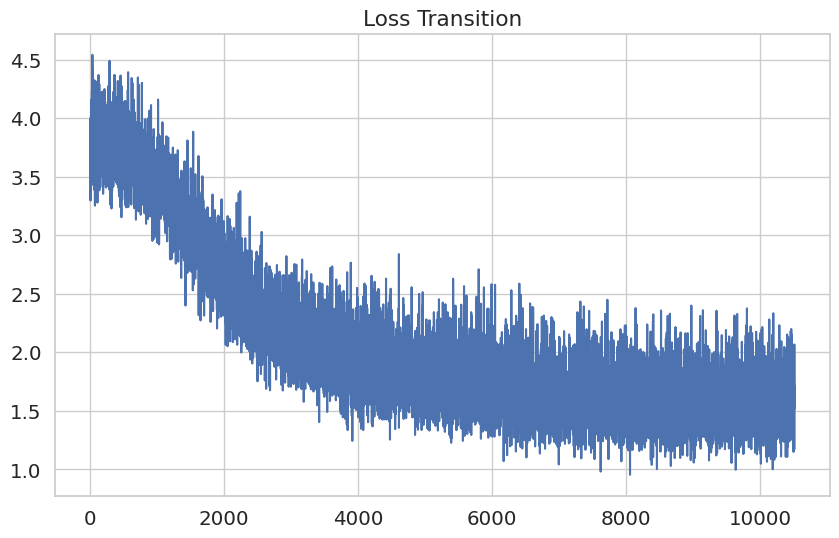

In [108]:
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv("loss.txt")
plt.plot(data)
plt.title("Loss Transition")
plt.show()

## Generate Text with Fine-Tuned Model

Again we check results with our test dataset (5 rows).<br>
As you can see below, it can output the completion very well, because it's fine-tuned.

In [109]:
test_data = pd.read_json("test_formatted.jsonl", lines=True)
test_data = test_data[::2]  # because it's duplicated
test_loader = DataLoader(
    list(zip(test_data["context"], [""] * len(test_data["context"]))),
    batch_size=1,
    shuffle=True,
    collate_fn=collate_batch
)

for i, (input, _, mask) in enumerate(test_loader):
    if i == 5:
        break
    print("---------- INPUT ----------")
    input_len = torch.sum(mask).cpu().numpy()
    print(tokenizer.decode(input[0][:input_len]))
    result_token, result_len = generate_text(
        model,
        input,
        mask,
        eos_id,
        pred_sequence_length=30)
    print("---------- RESULT ----------")
    print(tokenizer.decode(result_token[0][:result_len]))

---------- INPUT ----------
name : The Waterman | Type : restaurant | food : Indian | price : high | area : riverside | family friendly : no | near : Raja Indian Cuisine

---------- RESULT ----------
name : The Waterman | Type : restaurant | food : Indian | price : high | area : riverside | family friendly : no | near : Raja Indian Cuisine
The Waterman is a family friendly restaurant with a high price range . It is located near Raja Indian Cuisine .<|endoftext|>
---------- INPUT ----------
name : The Waterman | Type : restaurant | food : Italian | price : high | area : city centre | family friendly : yes | near : Raja Indian Cuisine

---------- RESULT ----------
name : The Waterman | Type : restaurant | food : Italian | price : high | area : city centre | family friendly : yes | near : Raja Indian Cuisine
The Waterman is a high priced Italian restaurant located near the Raja Indian Cuisine . It is located in the city centre .<|endoftext|>
---------- INPUT ----------
name : Blue Spice |

In [110]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

294912

In [111]:
# Install required packages (run once)
!pip install sacrebleu rouge-score matplotlib seaborn pandas
!git clone https://github.com/tuetschek/e2e-metrics.git

fatal: destination path 'e2e-metrics' already exists and is not an empty directory.


In [112]:
import torch
import json
import sacrebleu
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm

sns.set(style="whitegrid", font_scale=1.3, rc={"figure.figsize": (10, 6)})

# Load test data
test_data = pd.read_json("test_formatted.jsonl", lines=True)
test_data = test_data[::2].reset_index(drop=True)  # remove duplicates

# Helper: generate text using your trained model (same as in notebook)
def generate(model, tokenizer, context, max_new_tokens=50):
    model.eval()
    inputs = tokenizer(context + "\n", return_tensors="pt").to(device)
    input_ids = inputs.input_ids
    attention_mask = inputs.attention_mask
    
    generated = model.generate(
        input_ids,
        attention_mask=attention_mask,
        max_new_tokens=max_new_tokens,
        do_sample=False,
        pad_token_id=tokenizer.eos_token_id,
    )
    return tokenizer.decode(generated[0], skip_special_tokens=True).split("\n")[-1].strip()

# Generate predictions
references = []
hypotheses = []

print("Generating predictions on test set...")
for _, row in tqdm(test_data.iterrows(), total=len(test_data)):
    pred = generate(model, tokenizer, row["context"])
    hypotheses.append(pred)
    references.append(row["completion"])

# Save for official E2E metric script
with open("hyp.txt", "w") as f:
    for h in hypotheses:
        f.write(h + "\n")

with open("ref.txt", "w") as f:
    for r in references:
        f.write(r + "\n")

Generating predictions on test set...


100%|██████████| 2347/2347 [09:48<00:00,  3.99it/s]


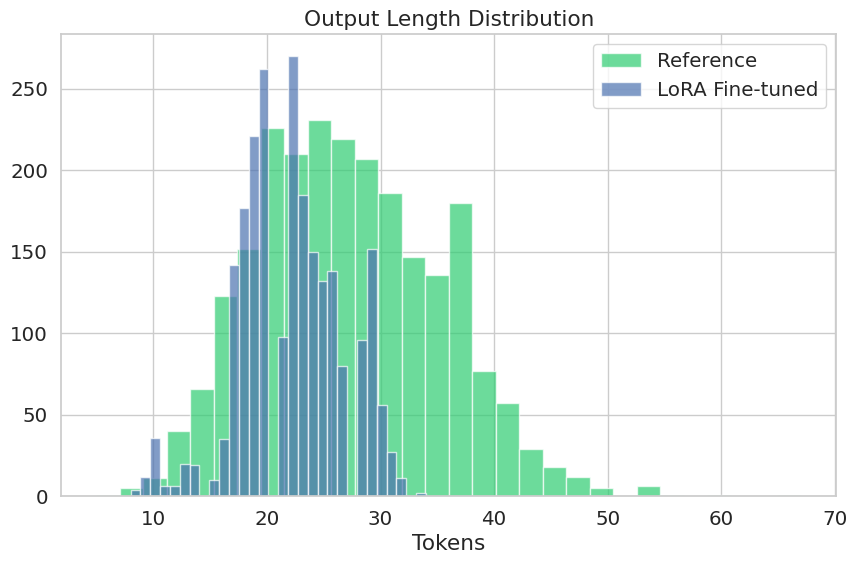

In [113]:
lens_ref = [len(r.split()) for r in references]
lens_hyp = [len(h.split()) for h in hypotheses]

plt.hist(lens_ref, alpha=0.7, bins=30, label="Reference", color="#2ecc71")
plt.hist(lens_hyp, alpha=0.7, bins=30, label="LoRA Fine-tuned")
plt.legend()
plt.title("Output Length Distribution")
plt.xlabel("Tokens")
plt.show()